<a href="https://colab.research.google.com/github/zaeyonglee/8th-Advanced-Toyproject/blob/main/Preprocessing/Data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


[상관계수 TOP 20 (abs Spearman 기준)]
                                                   pearson  spearman  \
Number of Intersections                           0.309721  0.157255   
Number of Bus Stops                               0.275908  0.067905   
Number of Subway Stations                         0.066068  0.063949   
 Delivery-Focused Businesses                      0.039085  0.060452   
Number of Restaurants                             0.019820  0.053959   
Number of CCTV Cameras                            0.010093  0.020094   
 Number of Automated Traffic Enforcement Cameras -0.001836 -0.002408   
Speed Bump Height                                -0.001606 -0.002110   
Traffic Volume                                    0.009591 -0.001524   

                                                   kendall  abs_spearman  
Number of Intersections                           0.157103      0.157255  
Number of Bus Stops                               0.067856      0.067905  
Number of Subway Stat

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49832 (\N{HANGUL SYLLABLE SEUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

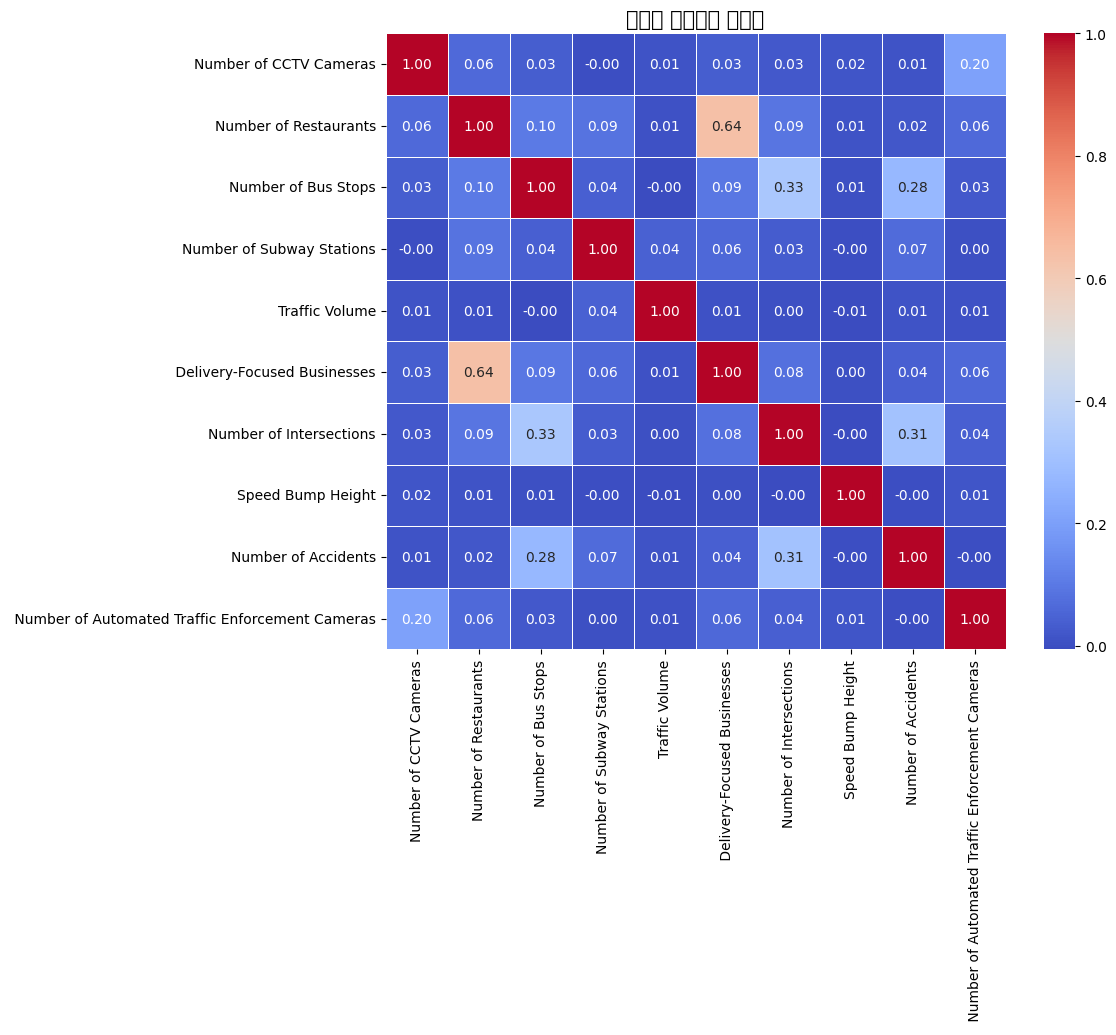

/usr/local/lib/python3.12/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


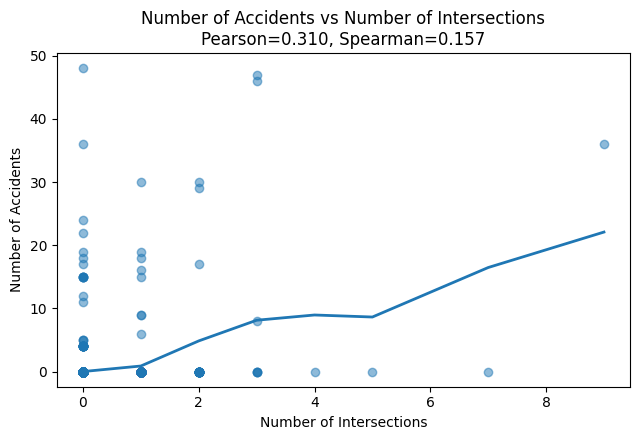

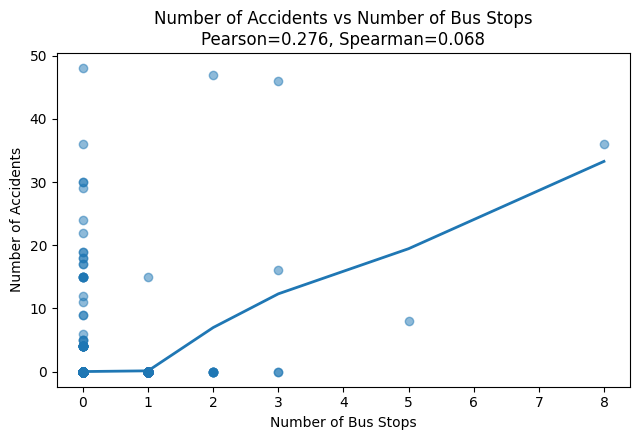

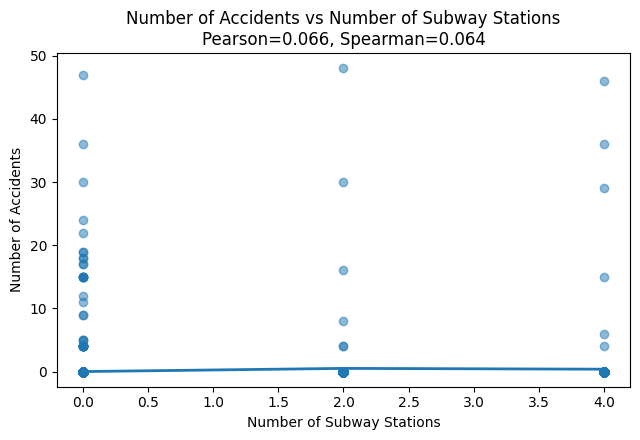

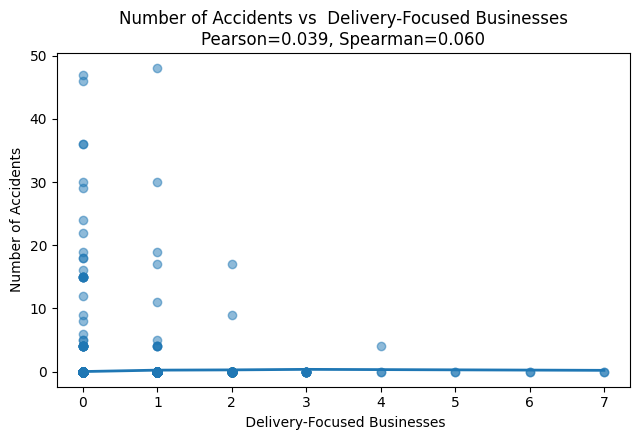

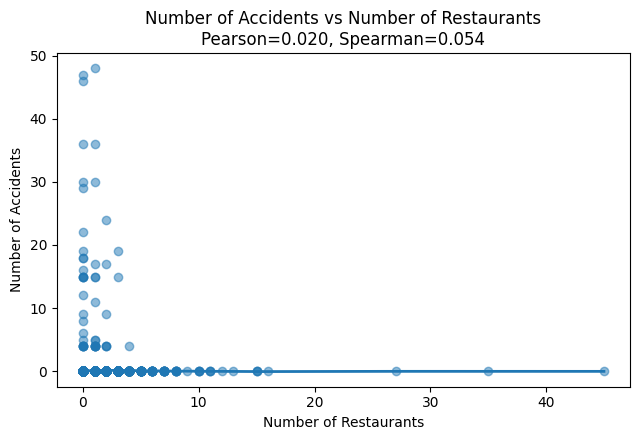

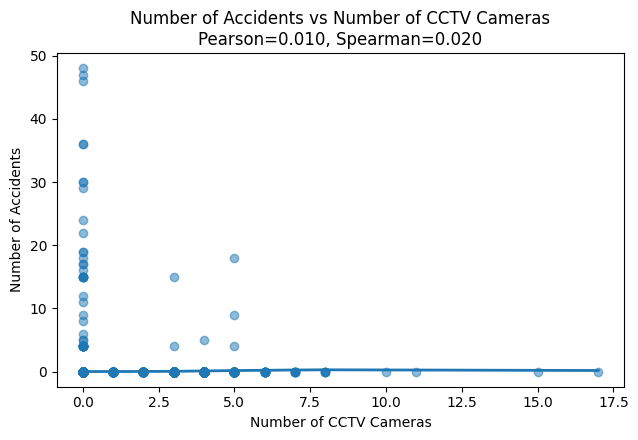

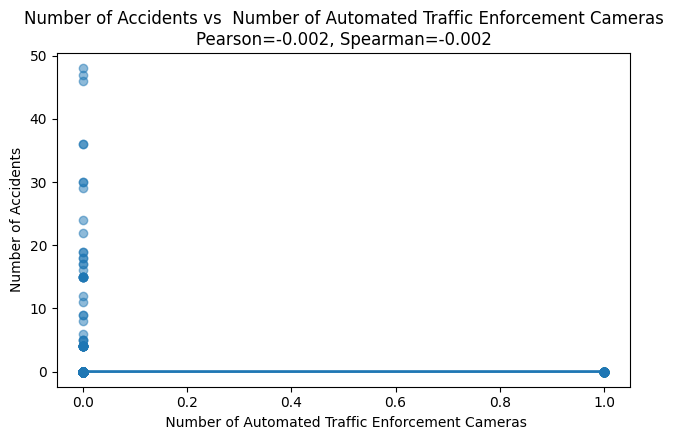

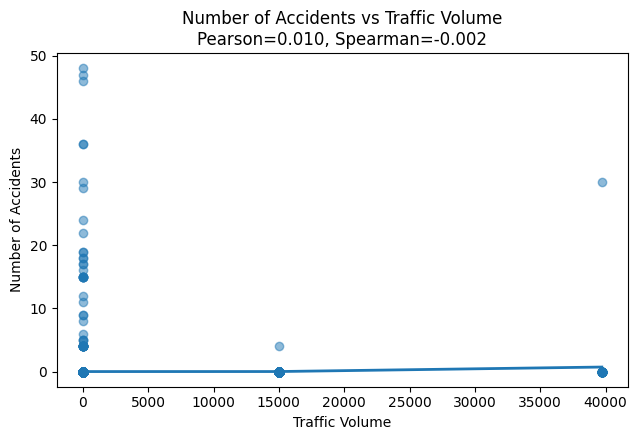


[RandomForest Feature Importance TOP 20]
Number of Bus Stops                                 0.346061
Number of Intersections                             0.225959
Number of Subway Stations                           0.174746
Number of Restaurants                               0.092535
Traffic Volume                                      0.065923
 Delivery-Focused Businesses                        0.055750
Number of CCTV Cameras                              0.036723
 Number of Automated Traffic Enforcement Cameras    0.002095
Speed Bump Height                                   0.000208
dtype: float64


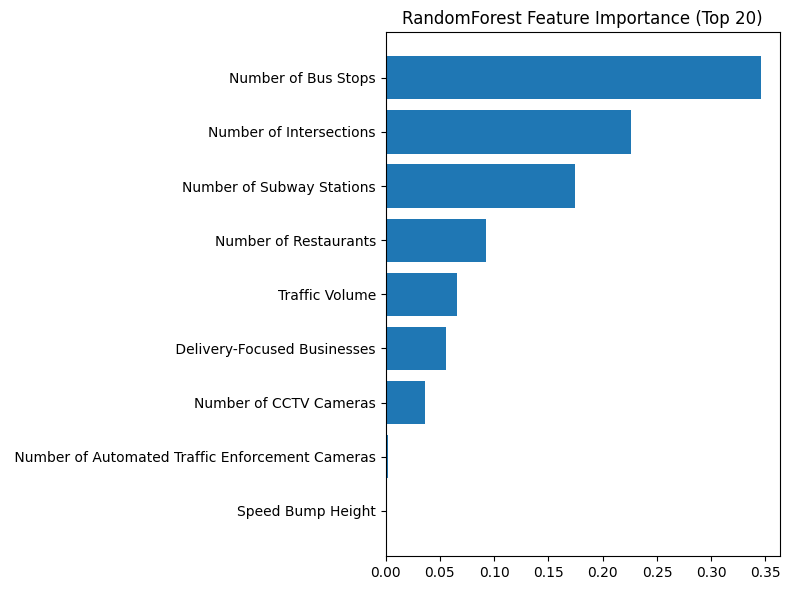

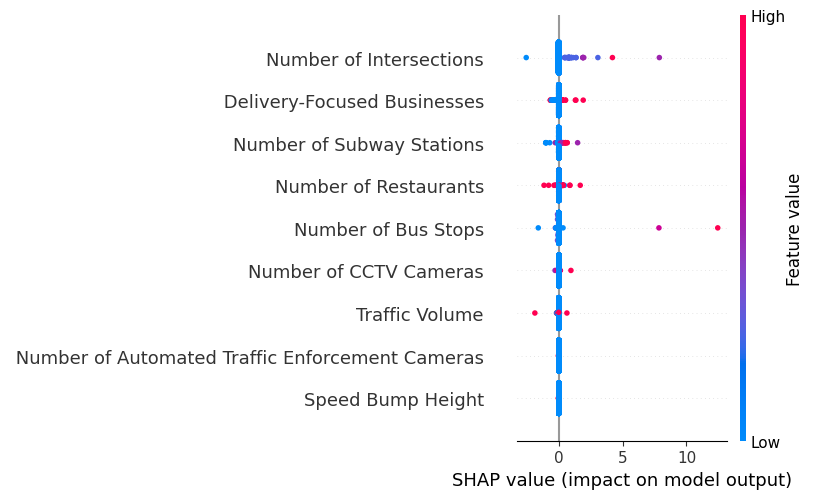

In [ ]:
# ============================================
# Correlation + Plot + (Optional) SHAP Pipeline
# ============================================

import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl

# ---------- (1) 한글 폰트 설정 (Mac/Windows/Linux 최대한 대응) ----------
def set_korean_font():
    candidates = [
        "AppleGothic",      # macOS
        "Malgun Gothic",    # Windows
        "NanumGothic",      # Linux (설치 필요)
        "Noto Sans CJK KR", # Linux (설치 필요)
    ]
    available = set([f.name for f in mpl.font_manager.fontManager.ttflist])
    for font in candidates:
        if font in available:
            plt.rcParams["font.family"] = font
            break
    plt.rcParams["axes.unicode_minus"] = False

set_korean_font()

# ---------- (2) 데이터 로드 ----------
path = "/content/사고위험지수_최종순위(1).csv"
df = pd.read_csv(path)
target_col = "Number of Accidents"   # 예: "사고건수" 또는 "사고위험지수" 등 (원래 '사고지수'였으나, 데이터프레임 컬럼에 맞춰 수정)

if target_col not in df.columns:
    raise ValueError(
        f"target_col='{target_col}' 이(가) df.columns에 없습니다.\n"
        f"현재 컬럼 예시(앞 30개): {df.columns[:30].tolist()}"
    )

# ---------- (3) 숫자형 컬럼 자동 선택 ----------
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in num_cols if c != target_col]

if len(feature_cols) == 0:
    raise ValueError("숫자형 설명변수가 없습니다. (타겟 제외 후 feature_cols가 비었습니다)")

# ---------- (4) 상관계수 계산: Pearson / Spearman / Kendall ----------
corr_pearson = df[feature_cols + [target_col]].corr(method="pearson")[target_col].drop(target_col)
corr_spearman = df[feature_cols + [target_col]].corr(method="spearman")[target_col].drop(target_col)
corr_kendall  = df[feature_cols + [target_col]].corr(method="kendall")[target_col].drop(target_col)

corr_table = pd.DataFrame({
    "pearson": corr_pearson,
    "spearman": corr_spearman,
    "kendall": corr_kendall,
    "abs_spearman": corr_spearman.abs()
}).sort_values("abs_spearman", ascending=False)

print("\n[상관계수 TOP 20 (abs Spearman 기준)]")
print(corr_table.head(20))

# ---------- (5) 상관 히트맵 (상위 N개 변수만) ----------

# 1. 숫자형 데이터만 선택 (상관계수는 숫자끼리만 계산 가능)
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# 2. 상관계수 행렬 계산 (기본값이 pearson)
corr_matrix = numeric_df.corr()

# 3. 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix,
            annot=True,      # 각 칸에 숫자 표시
            fmt=".2f",       # 소수점 둘째자리까지
            cmap='coolwarm', # 색상 조합 (양수는 빨강, 음수는 파랑)
            linewidths=0.5,  # 칸 사이 간격
            cbar=True)       # 오른쪽에 컬러바 표시

plt.title("피어슨 상관계수 히트맵", fontsize=15)
plt.show()

# ---------- (6) 산점도 + LOWESS(비선형/구간효과 확인) ----------
# LOWESS는 statsmodels 필요
try:
    import statsmodels.api as sm
    has_sm = True
except Exception:
    has_sm = False
    print("\n[주의] statsmodels가 없어 LOWESS 라인을 생략하고 산점도만 그립니다.")

plots_n = min(12, len(feature_cols))  # 너무 많으면 12개까지만 기본 표시
# Ensure top_features is defined. It's usually defined in section (5) for heatmap.
# If running this section independently, ensure top_features is available.
# Re-create top_features from corr_table.index if not already done, or ensure it's correct.
if 'top_features' not in locals() or 'top_features' not in globals():
    top_n = min(20, len(feature_cols))
    top_features = corr_table.index[:top_n].tolist()

# Filter plot_features to ensure all columns exist in df
plot_features = [col for col in top_features[:plots_n] if col in df.columns]

for col in plot_features:
    x = df[col]
    y = df[target_col]

    # 유효한 값만 (결측 제거)
    mask = x.notna() & y.notna()
    x2, y2 = x[mask], y[mask]

    plt.figure(figsize=(6.5, 4.5))
    plt.scatter(x2, y2, alpha=0.5)
    plt.xlabel(col)
    plt.ylabel(target_col)
    plt.title(f"{target_col} vs {col}\n"
              f"Pearson={corr_pearson[col]:.3f}, Spearman={corr_spearman[col]:.3f}")

    if has_sm and len(x2) >= 20:
        # LOWESS (비선형 추세)
        lowess = sm.nonparametric.lowess(y2, x2, frac=0.35, it=0, return_sorted=True)
        plt.plot(lowess[:, 0], lowess[:, 1], linewidth=2)

    plt.tight_layout()
    plt.show()

# ---------- (7) (선택) 비선형 영향도: RandomForest + SHAP ----------
# 필요 없으면 아래 블록 전체 주석 처리하세요.
do_shap = True

if do_shap:
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor

    # 모델용 X/y (결측 간단 처리: 중앙값 대체)
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    X = X.fillna(X.median(numeric_only=True))

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    rf = RandomForestRegressor(
        n_estimators=400,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    fi = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
    print("\n[RandomForest Feature Importance TOP 20]")
    print(fi.head(20))

    # 중요도 bar plot
    top_m = min(20, len(fi))
    plt.figure(figsize=(8, 6))
    plt.barh(fi.head(top_m).index[::-1], fi.head(top_m).values[::-1])
    plt.title("RandomForest Feature Importance (Top 20)")
    plt.tight_layout()
    plt.show()

    # SHAP (설치돼 있으면)
    try:
        import shap
        explainer = shap.TreeExplainer(rf)
        shap_values = explainer.shap_values(X_test)

        # SHAP summary plot (방향성/크기 해석 가능)
        shap.summary_plot(shap_values, X_test, show=True)

    except Exception as e:
        print("\n[주의] SHAP 실행 실패(미설치 등):", e)
        print("SHAP을 쓰려면: pip install shap")

#---------
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr

def scatter_with_corr(df, x_col, y_col):
    x = df[x_col]
    y = df[y_col]

    p = pearsonr(x, y)[0]
    s = spearmanr(x, y)[0]

    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, alpha=0.5)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(
        f"{y_col} vs {x_col}\n"
        f"Pearson={p:.3f}, Spearman={s:.3f}"
    )
    plt.tight_layout()
    plt.show()
def jitter_scatter(df, x_col, y_col, jitter=0.15):
    x = df[x_col] + np.random.uniform(-jitter, jitter, size=len(df))
    y = df[y_col] + np.random.uniform(-jitter, jitter, size=len(df))

    p = pearsonr(df[x_col], df[y_col])[0]
    s = spearmanr(df[x_col], df[y_col])[0]

    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, alpha=0.4)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(
        f"{y_col} vs {x_col} (jittered)\n"
        f"Pearson={p:.3f}, Spearman={s:.3f}"
    )
    plt.tight_layout()
    plt.show()
import statsmodels.api as sm

def scatter_with_lowess(df, x_col, y_col):
    x = df[x_col]
    y = df[y_col]

    p = pearsonr(x, y)[0]
    s = spearmanr(x, y)[0]

    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, alpha=0.4)

    # LOWESS
    lowess = sm.nonparametric.lowess(y, x, frac=0.4)
    plt.plot(lowess[:, 0], lowess[:, 1], linewidth=2)

    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(
        f"{y_col} vs {x_col}\n"
        f"Pearson={p:.3f}, Spearman={s:.3f}"
    )
    plt.tight_layout()
    plt.show()



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr

def scatter_with_corr(df, x_col, y_col):
    x = df[x_col]
    y = df[y_col]

    p = pearsonr(x, y)[0]
    s = spearmanr(x, y)[0]

    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, alpha=0.5)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(
        f"{y_col} vs {x_col}\n"
        f"Pearson={p:.3f}, Spearman={s:.3f}"
    )
    plt.tight_layout()
    plt.show()


In [ ]:
def jitter_scatter(df, x_col, y_col, jitter=0.15):
    x = df[x_col] + np.random.uniform(-jitter, jitter, size=len(df))
    y = df[y_col] + np.random.uniform(-jitter, jitter, size=len(df))

    p = pearsonr(df[x_col], df[y_col])[0]
    s = spearmanr(df[x_col], df[y_col])[0]

    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, alpha=0.4)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(
        f"{y_col} vs {x_col} (jittered)\n"
        f"Pearson={p:.3f}, Spearman={s:.3f}"
    )
    plt.tight_layout()
    plt.show()

In [ ]:
import statsmodels.api as sm

def scatter_with_lowess(df, x_col, y_col):
    x = df[x_col]
    y = df[y_col]

    p = pearsonr(x, y)[0]
    s = spearmanr(x, y)[0]

    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, alpha=0.4)

    # LOWESS
    lowess = sm.nonparametric.lowess(y, x, frac=0.4)
    plt.plot(lowess[:, 0], lowess[:, 1], linewidth=2)

    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(
        f"{y_col} vs {x_col}\n"
        f"Pearson={p:.3f}, Spearman={s:.3f}"
    )
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# =========================
# 0) 설정
# =========================
INPUT_CSV = "/content/사고위험지수_최종순위.csv"

# 필터 조건
TOP_PCT = 0.01              # ✅ 사고위험지수 상위 1%
ACCIDENT_COL = "사고건수"    # ✅ 사고건수 컬럼명
TARGET_COL = "사고위험지수"  # ✅ 위험지수 컬럼명

# 출력 파일명 (필터링/클러스터링 결과)
FILTERED_CSV = "top1pct_risk_acc0_filtered.csv"
OUTPUT_CSV = "top1pct_risk_acc0_kmeans.csv"
EVAL_CSV = "top1pct_risk_acc0_kmeans_k_eval.csv"
SUMMARY_CSV = "top1pct_risk_acc0_kmeans_cluster_summary.csv"

RANDOM_STATE = 42
K_MIN, K_MAX = 2, 10  # 데이터가 아주 적어지면 K_MAX가 자동으로 줄어듦

# =========================
# 1) 데이터 로드
# =========================
df = pd.read_csv(INPUT_CSV, encoding="utf-8-sig")

# 필수 컬럼 체크
for col in [TARGET_COL, ACCIDENT_COL]:
    if col not in df.columns:
        raise ValueError(f"'{col}' 칼럼이 CSV에 없습니다. 현재 칼럼: {list(df.columns)}")

# =========================
# 2) (필터링) 사고위험지수 상위 1% + 사고건수 0
# =========================
thr = df[TARGET_COL].quantile(1 - TOP_PCT)
df_f = df[df[TARGET_COL] >= thr].copy()
df_f = df_f[df_f[ACCIDENT_COL] == 0].copy()

print(f"\n===== 필터링 결과 =====")
print(f"상위 {TOP_PCT*100:.1f}% 사고위험지수 임계값: {thr:.6f}")
print(f"상위 {TOP_PCT*100:.1f}% 행 수: {len(df[df[TARGET_COL] >= thr])}")
print(f"그 중 사고건수=0 행 수: {len(df_f)}")

if len(df_f) < 10:
    raise ValueError("필터링 후 데이터가 너무 적습니다(10개 미만). TOP_PCT를 0.02~0.05로 늘려보세요.")

# 필터링 결과 저장(발표용/검증용)
df_f.to_csv(FILTERED_CSV, index=False, encoding="utf-8-sig")
print(f"✅ 필터링 데이터 저장: {FILTERED_CSV}")

# =========================
# 3) 클러스터링 입력 피처 선택
#    - 사고위험지수는 제외(해석용)
#    - 문자열(도로명주소 등)은 자동 제외(숫자형만 선택)
# =========================
numeric_cols = df_f.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c != TARGET_COL]

# (권장) 사고건수는 0으로 고정이라 정보가 없으니 제거
if ACCIDENT_COL in feature_cols:
    feature_cols.remove(ACCIDENT_COL)

if len(feature_cols) < 2:
    raise ValueError(f"클러스터링에 쓸 숫자형 피처가 너무 적습니다. feature_cols={feature_cols}")

X = df_f[feature_cols].copy()

# =========================
# 4) 전처리 (교통량 log 변환 + 스케일링)
# =========================
traffic_col = "일평균교통량(대)"
if traffic_col in X.columns:
    if (X[traffic_col] < 0).any():
        raise ValueError(f"'{traffic_col}'에 음수 값이 있어 log 변환할 수 없습니다.")
    X[traffic_col] = np.log1p(X[traffic_col])

X = X.fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# =========================
# 5) K 후보 평가 (Elbow + Silhouette)
#    - 데이터 크기가 작을 수 있으니 K_MAX를 자동 조정
# =========================
max_k_allowed = min(K_MAX, len(df_f) - 1)  # silhouette 계산 위해 최소 2개 이상 필요
if max_k_allowed < K_MIN:
    raise ValueError(f"데이터가 너무 적어 KMeans를 돌릴 수 없습니다. 현재 행 수={len(df_f)}")

ks = list(range(K_MIN, max_k_allowed + 1))
inertias, silhouettes = [], []

for k in ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

eval_df = pd.DataFrame({"k": ks, "inertia": inertias, "silhouette": silhouettes})

print("\n===== K 평가 결과 (Elbow + Silhouette) =====")
print(eval_df.to_string(index=False))

# =========================
# 6) "적절한 K" 자동 선택
# =========================
best_sil = eval_df["silhouette"].max()
candidate_ks = eval_df.loc[eval_df["silhouette"] >= best_sil - 0.02, "k"].tolist()
selected_k = min(candidate_ks)

print(f"\n[선택된 K] silhouette 기준 best={best_sil:.4f}, 후보={candidate_ks} → 선택 K={selected_k}")

# =========================
# 7) 선택된 K로 최종 KMeans 학습
# =========================
final_km = KMeans(n_clusters=selected_k, random_state=RANDOM_STATE, n_init="auto")
df_f["cluster"] = final_km.fit_predict(X_scaled)

# =========================
# 8) 클러스터별 요약 (해석용)
# =========================
summary_cols = feature_cols + [TARGET_COL]
cluster_summary = df_f.groupby("cluster")[summary_cols].mean(numeric_only=True)

print("\n===== 클러스터별 평균 요약 (피처 + 사고위험지수) =====")
print(cluster_summary)

cluster_sizes = df_f["cluster"].value_counts().sort_index()
print("\n===== 클러스터 크기 =====")
print(cluster_sizes)

# =========================
# 9) 결과 저장
# =========================
df_f.to_csv(OUTPUT_CSV, index=False, encoding="utf-8-sig")
eval_df.to_csv(EVAL_CSV, index=False, encoding="utf-8-sig")
cluster_summary.to_csv(SUMMARY_CSV, encoding="utf-8-sig")

print(f"\n✅ 저장 완료: {OUTPUT_CSV}")
print(f"✅ 추가 저장: {EVAL_CSV}, {SUMMARY_CSV}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/사고위험지수_최종순위.csv'